In [78]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import os, csv

In [79]:
df = pd.read_csv("../cleaned_output.csv")
df.head()

,id,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q3: In what setting would you expect this food to be served? Please check all that apply,Q4: How much would you expect to pay for one serving of this food item?,Q5: What movie do you think of when thinking of this food item?,Q6: What drink would you pair with this food item?,"Q7: When you think about this food item, who does it remind you of?",Q8: How much hot sauce would you add to this food item?,Label
0,716549,3,6.0,"Week day lunch,At a party,Late night snack",5.0,cloudy with a chance of meatballs,coca cola,Friends,A little (mild),Pizza
1,715742,4,2.0,"Week day lunch,At a party,Late night snack",5.0,all sort of american young boy movies,coca cola,"Friends,Teachers,Strangers",NaN,Pizza
2,727333,3,5.0,"Week day lunch,Week day dinner,Weekend lunch,W...",NaN,action movie,coca cola,Friends,A moderate amount (medium),Pizza
3,606874,4,6.5,"Week day lunch,Week day dinner,Weekend lunch,W...",3.0,mamma mia,pop,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3.0,"Week day lunch,Week day dinner,Weekend lunch,W...",5.0,cloudy with a chance of meatballs,pop,"Siblings,Friends",A little (mild),Pizza


In [80]:
Q3 = 'Q3: In what setting would you expect this food to be served? Please check all that apply'
Q7 = 'Q7: When you think about this food item, who does it remind you of?'
Q8 = 'Q8: How much hot sauce would you add to this food item?'
Q5 = 'Q5: What movie do you think of when thinking of this food item?'
Q6 = 'Q6: What drink would you pair with this food item?'
Q2 = 'Q2: How many ingredients would you expect this food item to contain?'

def encode_comma_separated_features(df: pd.DataFrame, comma_separated_features: list) -> pd.DataFrame:
    for feature in comma_separated_features:
        if feature in df.columns:
            # Create a temporary series with lists of options
            options_series = df[feature].fillna('').str.split(',')
            
            # Get all unique options across all rows efficiently
            unique_options = set()
            for options_list in options_series:
                unique_options.update([opt.strip() for opt in options_list if opt.strip()])
                
            print(f"'{feature.split(':')[0]}' has {unique_options}\n")
            
            # Create binary columns in a vectorized way
            feature_prefix = feature.split(':')[0] + "_"
            for option in unique_options:
                # Use vectorized string operations instead of apply
                df[f"{feature_prefix}{option}"] = options_series.apply(
                    lambda x: any(opt.strip() == option for opt in x)
                )
            
            # Drop original column
            df.drop(columns=[feature], inplace=True)
    return df

def encode_categorical_features(df: pd.DataFrame, categorical_features: list) -> pd.DataFrame:
    df = pd.get_dummies(df, columns=categorical_features, drop_first=False, sparse=False)
    return df

In [81]:

df = df.drop(columns=[Q7, 'id'])  # Dropping Q7 as it doesn't show good correlations
comma_separated_features = [Q3, Q8]
df = encode_comma_separated_features(df, comma_separated_features)

categorical_columns = [Q5, Q6]
df = encode_categorical_features(df, categorical_columns)

df = df.dropna()  # Drop rows with NaN values

X = df.drop(columns=['Label']).to_numpy()

y = df['Label'].to_numpy()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

'Q3' has {'Weekend lunch', 'At a party', 'Weekend dinner', 'Week day lunch', 'Late night snack', 'Week day dinner'}

'Q8' has {'A little (mild)', 'A lot (hot)', 'I will have some of this food item with my hot sauce', 'A moderate amount (medium)'}



In [ ]:
# 60% for training and 20% validation, 20% for testing TODO: do we want to adjust this
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=3)

In [83]:
# Output data set splits
mapping = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test,
    'y_test': y_test
}
for name, data in mapping.items():
    pd.DataFrame(data).to_csv(f'dataset/{name}.csv', index=False)

In [84]:
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': loguniform(1e-4, 1e-1),
    'learning_rate_init': loguniform(1e-4, 1e-2),
    'learning_rate': ['constant', 'adaptive']
}

# Train MLP Classifier
mlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
# mlp = RandomizedSearchCV(
#     mlp, 
#     param_dist, 
#     n_iter=20,  # Number of parameter settings sampled
#     cv=5,       # 5-fold cross-validation
#     verbose=2,
#     n_jobs=-1,  # Use all available processors
#     random_state=1
# )
mlp.fit(X_train, y_train)

# Train bagged MLP Classifier
bagging = BaggingClassifier(mlp, n_estimators=10, max_samples=0.8, random_state=1, verbose=0)
bagging.fit(X_train, y_train)


/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [85]:
# Normalize the data
scaler = StandardScaler()
normalizer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [0, 1 ,2])
    ],
    remainder='passthrough'  # Leave other columns unchanged (not sure if this is the issue.. im too lacking )
)

X_train_norm = normalizer.fit_transform(X_train)
X_valid_norm = normalizer.transform(X_valid)
X_test_norm = normalizer.transform(X_test)

# Train MLP Classifier with normalized data
nmlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
nmlp.fit(X_train_norm, y_train)

# Train bagged MLP Classifier with normalized data
normBagging = BaggingClassifier(nmlp, n_estimators=10, max_samples=0.8, random_state=1)
normBagging.fit(X_train_norm, y_train)

/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [ ]:
def print_bias_variance_decomp(model, X_train, y_train, X_test, y_test):    
    expected_loss, bias, var = bias_variance_decomp(mlp,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=23)
    expected_loss_bagged, bias_bagged, var_bagged = bias_variance_decomp(bagging,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=23)
    expected_loss_norm, bias_norm, var_norm = bias_variance_decomp(nmlp,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=23)
    expected_loss_bagged_norm, bias_bagged_norm, var_bagged_norm = bias_variance_decomp(normBagging,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=23)

    print("Bias-Variance Decomposition Results")
    print("===================================")
    print(f"{'Model':<25} {'Expected Loss':<15} {'Bias':<15} {'Variance':<15}")
    print("-" * 70)
    print(f"{'MLP':<25} {expected_loss:.4f}{' '*10} {bias:.4f}{' '*10} {var:.4f}")
    print(f"{'Bagging MLP':<25} {expected_loss_bagged:.4f}{' '*10} {bias_bagged:.4f}{' '*10} {var_bagged:.4f}")
    print(f"{'Normalized MLP':<25} {expected_loss_norm:.4f}{' '*10} {bias_norm:.4f}{' '*10} {var_norm:.4f}")
    print(f"{'Normalized Bagging MLP':<25} {expected_loss_bagged_norm:.4f}{' '*10} {bias_bagged_norm:.4f}{' '*10} {var_bagged_norm:.4f}")

In [87]:
def export_model(model: MLPClassifier, filename: str, is_bagged: bool = False) -> None:
    """
    Save the bagged model. Note a bagged model is a collection of models, so we need to save each 
    one. This will also result different code for inference
    """
    if is_bagged:
        params = {}
        for i, estimator in enumerate(model.estimators_):
            for j in range(len(estimator.coefs_)):
                params[f'estimator_{i}_weights_{j}'] = estimator.coefs_[j]
                params[f'estimator_{i}_intercepts_{j}'] = estimator.intercepts_[j]
        params['num_estimators'] = len(model.estimators_)
        params['num_layers'] = len(model.estimators_[0].coefs_)
        params['classes'] = model.classes_
        np.savez(filename, **params)
    else:
        params = {f'weights_{i}': coef for i, coef in enumerate(model.coefs_)}
        params.update({f'biases_{i}': intercept for i, intercept in enumerate(model.intercepts_)})
        params['classes'] = model.classes_
        np.savez(filename, **params)

In [88]:
# Export the models
export_model(mlp, 'mlp_model.npz')
export_model(bagging, 'bagged_model.npz', is_bagged=True)

In [ ]:
def score_and_export_results(model: MLPClassifier, X_train: pd.DataFrame, y_train: pd.Series, 
                             X_valid: pd.DataFrame, y_valid: pd.Series, model_name: str, 
                             file_name: str) -> None:
    """
    Score the model and save the results of the model to file_name.
    """
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    print(f"Model: {model_name}")
    print(f"Training Score: {train_score:.4f}")
    print(f"Validation Score: {valid_score:.4f}\n")
    
    params = {
        "Model": model_name,
        "Training Score": train_score,
        "Validation Score": valid_score,
        "hidden_layer_sizes": "",
        "activation": "",
        "solver": "",
        "alpha": "",
        "learning_rate_init": "",
        "learning_rate": "",
        "n_estimators": "",
        "max_samples": ""
    }
    
    fieldnames = [
        "Model", "Training Score", "Validation Score", "hidden_layer_sizes", 
        "activation", "solver", "alpha", "learning_rate_init", "learning_rate", 
        "n_estimators", "max_samples"
    ]
    
        
        
    if isinstance(model, BaggingClassifier):
        base_model = model.estimator_  # Access base estimator
        params["n_estimators"] = model.n_estimators
        params["max_samples"] = model.max_samples

    if isinstance(model, MLPClassifier):
        params["hidden_layer_sizes"] = str(model.hidden_layer_sizes)
        params["activation"] = model.activation
        params["solver"] = model.solver
        params["alpha"] = model.alpha
        params["learning_rate_init"] = model.learning_rate_init
        if model.solver == 'sgd':
            params["learning_rate"] = model.learning_rate

    # Write to CSV
    file_exists = os.path.isfile(file_name)
    with open(file_name, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerows([params])

In [90]:
models = {
    "Base": (mlp, X_valid, y_valid, X_train, y_train),
    "Bagging": (bagging, X_valid, y_valid, X_train, y_train),
    "Normalized": (nmlp, X_valid_norm, y_valid, X_train_norm, y_train),
    "Normalized Bagging": (normBagging, X_valid_norm, y_valid, X_train_norm, y_train)
}

for name, (model, X_valid, y_valid, X_train, y_train) in models.items():    
    score_and_export_results(model, X_train, y_train, X_valid, y_valid, name, "model_results.csv")

Model: Base
Training Score: 0.9709
Validation Score: 0.9083
Model: Bagging
Training Score: 0.9472
Validation Score: 0.9052
Model: Normalized
Training Score: 0.9113
Validation Score: 0.9052
Model: Normalized Bagging
Training Score: 0.9549
Validation Score: 0.9113


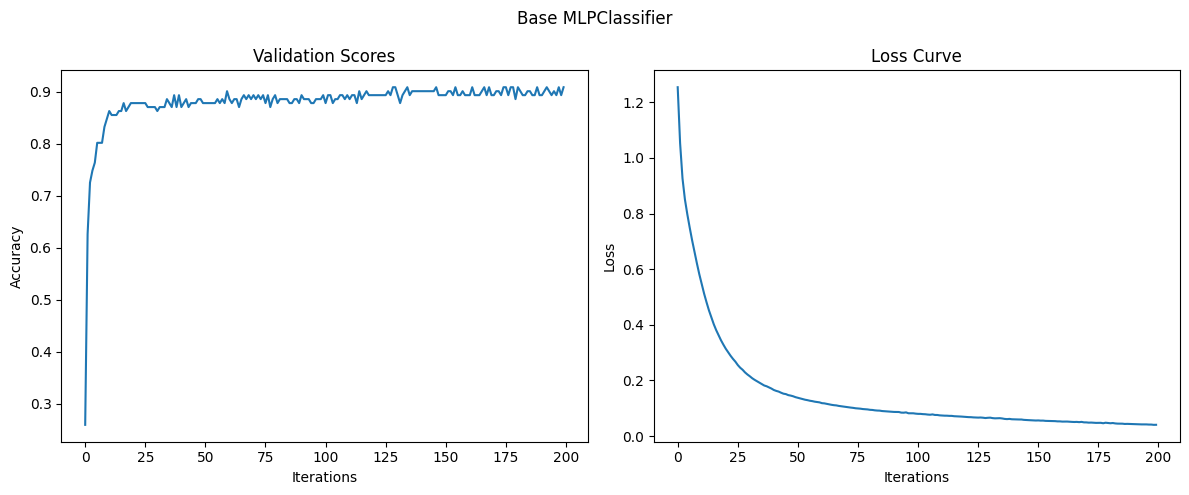

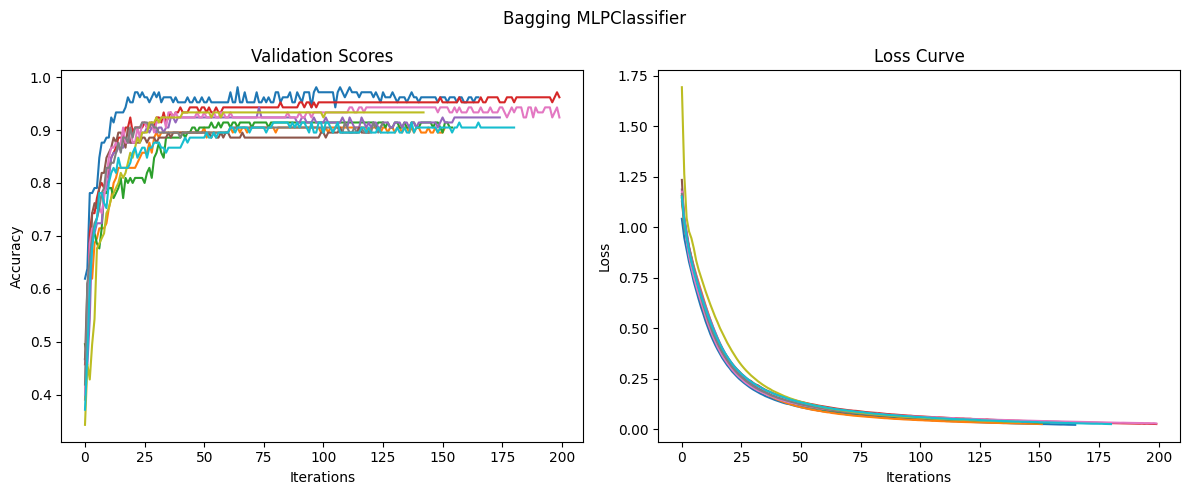

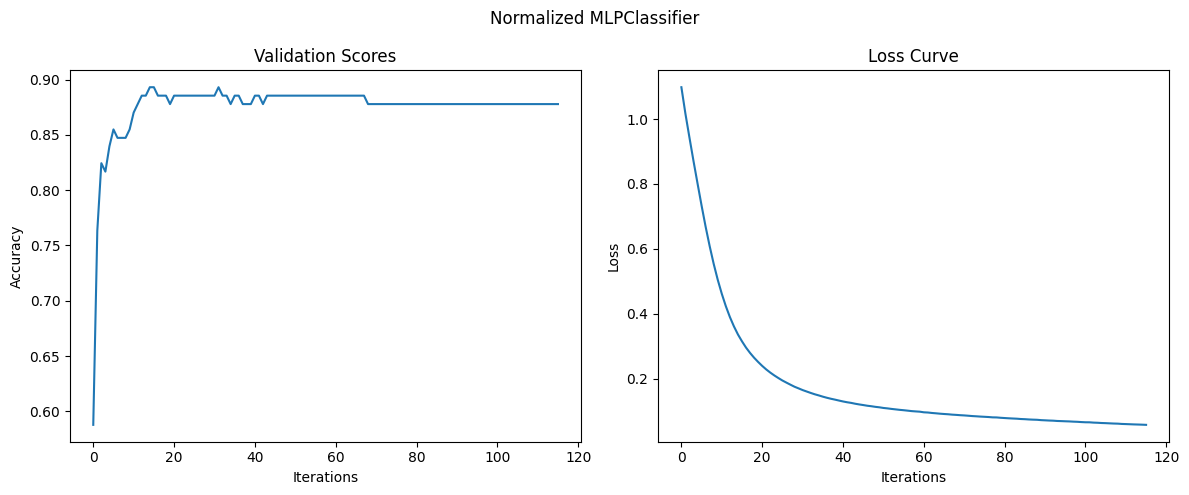

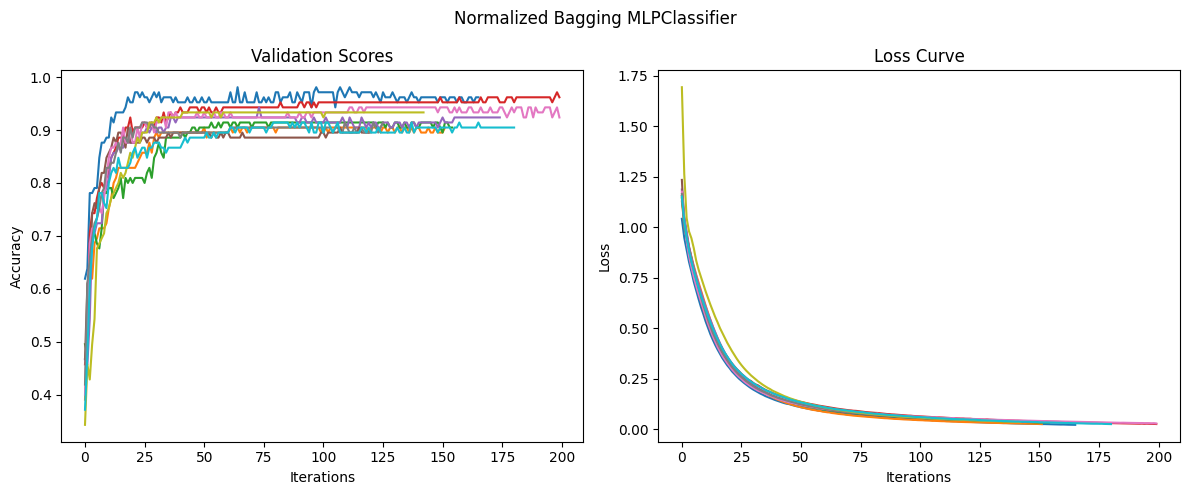

In [91]:
from plot import plot_single_model, plot_bagging_training_progress

plot_single_model(mlp, "Base MLPClassifier")
plot_bagging_training_progress(bagging, "Bagging MLPClassifier")
plot_single_model(nmlp, "Normalized MLPClassifier")
plot_bagging_training_progress(bagging, "Normalized Bagging MLPClassifier")